In [202]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.stats import pearsonr
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [38]:
full_data = pd.read_csv("data/online_shoppers_intention.csv")
cols = list(full_data.columns)

In [39]:
full_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [40]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## Data Preprocessing

### Feature Transformation

In [53]:
data = full_data.copy()
booleanDic = {True:1, False:0}

data["Weekend"] = data["Weekend"].map(booleanDic)
data["Revenue"] = data["Revenue"].map(booleanDic)

X = data.copy().drop("Revenue",axis=1).to_numpy()
y = data["Revenue"].to_numpy()

In [44]:
num_cols = cols[:10]
cat_cols = cols[10:]
cat_cols.remove('Month')
cat_cols.remove('VisitorType')
ohe_cols = ["Month","VisitorType"]

In [47]:
num_pipeline = Pipeline([
        ('standard_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", OneHotEncoder(), ohe_cols)
],remainder="passthrough")

In [92]:
data_prepared = full_pipeline.fit_transform(data)

In [93]:
encoded_cols = list(full_pipeline.transformers_[1][1].get_feature_names(ohe_cols))

In [107]:
columns = num_cols+encoded_cols+cat_cols
dropfirst = ["Month_Aug","VisitorType_New_Visitor"]

In [108]:
dataDF = pd.DataFrame(data_prepared, columns=columns).reset_index(drop=True)
dataDF = dataDF.copy().drop(columns=dropfirst)

In [111]:
X = dataDF.copy().drop("Revenue",axis=1).to_numpy()
y = dataDF["Revenue"].to_numpy()

columns = list(dataDF.columns)
columns.remove("Revenue")

### SMOTE

In [112]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImPipeline
# https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [113]:
from collections import Counter

In [114]:
oversample = SMOTE()
y=y.astype('float')
X1,y1 = oversample.fit_resample(X,y)
counter = Counter(y1)
print(counter)

X1 = pd.DataFrame(X1,columns=columns).reset_index(drop=True)
X1["Revenue"] = y1

Counter({0.0: 10422, 1.0: 10422})


#### SMOTE with Undersampling

In [115]:
over = SMOTE(sampling_strategy=0.30)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('o', over), ('u', under)]
pipeline = ImPipeline(steps=steps)

X2, y2 = pipeline.fit_resample(X, y)
print(Counter(y2))

X2 = pd.DataFrame(X2,columns=columns).reset_index(drop=True)
X2["Revenue"] = y2

Counter({0.0: 6252, 1.0: 3126})


### Splitting into Train, Test

In [116]:
train_set, test_set = train_test_split(dataDF, test_size=0.2, random_state=28)

train_y = train_set["Revenue"].to_numpy().astype('float')
train_set = train_set.drop("Revenue",axis=1)
#train_prepared = full_pipeline.fit_transform(train_set)

test_y = test_set["Revenue"].to_numpy()
test_set = test_set.drop("Revenue",axis=1).astype('float')
#test_prepared = full_pipeline.fit_transform(test_set)

train_X = pd.DataFrame(train_set, columns=columns).reset_index(drop=True)
#train_X = train_prepared.copy()
test_X = pd.DataFrame(test_set, columns=columns).reset_index(drop=True)
#test_X = test_prepared.copy()

In [117]:
train_set, test_set = train_test_split(X1, test_size=0.2, random_state=28)

train_y1 = train_set["Revenue"].to_numpy().astype('float')
train_set = train_set.drop("Revenue",axis=1)

test_y1 = test_set["Revenue"].to_numpy()
test_set = test_set.drop("Revenue",axis=1).astype('float')

train_X1 = pd.DataFrame(train_set, columns=columns).reset_index(drop=True)
test_X1 = pd.DataFrame(test_set, columns=columns).reset_index(drop=True)

In [118]:
train_set, test_set = train_test_split(X2, test_size=0.2, random_state=28)

train_y2 = train_set["Revenue"].to_numpy().astype('float')
train_set = train_set.drop("Revenue",axis=1)

test_y2 = test_set["Revenue"].to_numpy()
test_set = test_set.drop("Revenue",axis=1).astype('float')

train_X2 = pd.DataFrame(train_set, columns=columns).reset_index(drop=True)
test_X2= pd.DataFrame(test_set, columns=columns).reset_index(drop=True)

## Logistic Regression

In [119]:
LR_model = LogisticRegression(penalty='none',max_iter=1000)
LR_model.fit(train_X,train_y)

LogisticRegression(max_iter=1000, penalty='none')

In [120]:
vif_data = pd.DataFrame()
vif_data["feature"] = train_X.columns
vif_data["VIF"] = [variance_inflation_factor(train_X.values,i) for i in range(len(train_X.columns))]

In [121]:
vif_data

,feature,VIF
0,Administrative,1.944276
1,Administrative_Duration,1.709029
2,Informational,1.868847
3,Informational_Duration,1.748690
4,ProductRelated,4.533811
5,ProductRelated_Duration,4.424628
6,BounceRates,6.468400
7,ExitRates,7.203787
8,PageValues,1.060139
9,SpecialDay,1.327594


In [122]:
def cross_validate_scores(model,X,y,scoring=['accuracy','precision','f1','roc_auc'],cv=5):
    cv_results = cross_validate(model,X,y,scoring=scoring,cv=cv)
    print("%s\n-------------------" % str(model))
    for metric in cv_results:
        print("%s: %f" % (metric, np.mean(cv_results[metric])))

In [123]:
cross_validate_scores(LR_model, train_X, train_y)

LogisticRegression(max_iter=1000, penalty='none')
-------------------
fit_time: 0.529247
score_time: 0.018958
test_accuracy: 0.884936
test_precision: 0.755229
test_f1: 0.516060
test_roc_auc: 0.893884


In [124]:
pred = LR_model.predict(test_X)

accuracy=accuracy_score(test_y, pred)
precision=precision_score(test_y, pred)
f1=f1_score(test_y, pred)
roc = roc_auc_score(test_y, pred)

metrics = [accuracy,precision,f1,roc]
metric_names = ['accuracy','precision','f1','ROC-AUC']

for i in range(len(metrics)):
    print(metric_names[i]+": ",metrics[i])

accuracy:  0.8868613138686131
precision:  0.723404255319149
f1:  0.49364791288566245
ROC-AUC:  0.6749645331541324


### SMOTE

In [127]:
LR_model = LogisticRegression(max_iter=1000,penalty='none')
LR_model.fit(train_X2,train_y2)

LogisticRegression(max_iter=1000, penalty='none')

In [128]:
cross_validate_scores(LR_model, train_X2, train_y2)

LogisticRegression(max_iter=1000, penalty='none')
-------------------
fit_time: 0.371770
score_time: 0.014261
test_accuracy: 0.834312
test_precision: 0.836702
test_f1: 0.711600
test_roc_auc: 0.908127


In [129]:
pred = LR_model.predict(test_X2)

accuracy=accuracy_score(test_y2, pred)
precision=precision_score(test_y2, pred)
f1=f1_score(test_y2, pred)
roc = roc_auc_score(test_y2, pred)

metrics = [accuracy,precision,f1,roc]
metric_names = ['accuracy','precision','f1','ROC-AUC']

for i in range(len(metrics)):
    print(metric_names[i]+": ",metrics[i])

accuracy:  0.8219616204690832
precision:  0.8539325842696629
f1:  0.6946983546617916
ROC-AUC:  0.7662707218050967


## Random Forest

In [130]:
RF_model = RandomForestClassifier(n_estimators=20,random_state=0)
RF_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=20, random_state=0)

In [131]:
param_grid = { 
    'n_estimators': np.arange(20,200,20),
    'max_features': ['auto', 'log2']
}

grid = GridSearchCV(RF_model,param_grid=param_grid)
grid.fit(train_X,train_y)
print(grid.best_params_)

{'max_features': 'log2', 'n_estimators': 180}


In [134]:
RF_model = RandomForestClassifier(n_estimators=180,random_state=0, max_features='log2')
RF_model.fit(train_X, train_y)

pred = RF_model.predict(test_X)

In [135]:
print(confusion_matrix(test_y,pred))
print(classification_report(test_y,pred))
print(accuracy_score(test_y, pred))

[[2018   85]
 [ 165  198]]
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      2103
         1.0       0.70      0.55      0.61       363

    accuracy                           0.90      2466
   macro avg       0.81      0.75      0.78      2466
weighted avg       0.89      0.90      0.89      2466

0.8986212489862125


### SMOTE

In [136]:
RF_model = RandomForestClassifier(n_estimators=20,random_state=0)
RF_model.fit(train_X2, train_y2)

RandomForestClassifier(n_estimators=20, random_state=0)

In [137]:
param_grid = { 
    'n_estimators': np.arange(20,200,20),
    'max_features': ['auto', 'log2']
}

grid = GridSearchCV(RF_model,param_grid=param_grid)
grid.fit(train_X2,train_y2)
print(grid.best_params_)

{'max_features': 'auto', 'n_estimators': 80}


In [138]:
RF_model = RandomForestClassifier(n_estimators=80,random_state=0)
RF_model.fit(train_X2, train_y2)

pred = RF_model.predict(test_X2)

In [139]:
print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1129   98]
 [ 121  528]]
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1227
         1.0       0.84      0.81      0.83       649

    accuracy                           0.88      1876
   macro avg       0.87      0.87      0.87      1876
weighted avg       0.88      0.88      0.88      1876

0.8832622601279317


## Boosted Trees

In [203]:
boost = AdaBoostClassifier(n_estimators=100, random_state=0)
boost.fit(train_X, train_y)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [204]:
param_grid = { 
    'n_estimators': np.arange(20,200,20),
    'algorithm': ['SAMME','SAMME.R']
}

grid = GridSearchCV(boost,param_grid=param_grid)
grid.fit(train_X,train_y)
print(grid.best_params_)

{'algorithm': 'SAMME', 'n_estimators': 20}


In [205]:
boost = AdaBoostClassifier(n_estimators=20, random_state=0, algorithm='SAMME')
boost.fit(train_X, train_y)

pred = boost.predict(test_X)

In [206]:
print(confusion_matrix(test_y,pred))
print(classification_report(test_y,pred))
print(accuracy_score(test_y, pred))

[[1994  109]
 [ 147  216]]
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      2103
         1.0       0.66      0.60      0.63       363

    accuracy                           0.90      2466
   macro avg       0.80      0.77      0.78      2466
weighted avg       0.89      0.90      0.89      2466

0.8961881589618816


### SMOTE

In [207]:
boost = AdaBoostClassifier(n_estimators=100, random_state=0)
boost.fit(train_X2, train_y2)

AdaBoostClassifier(n_estimators=100, random_state=0)

In [208]:
param_grid = { 
    'n_estimators': np.arange(20,200,20),
    'algorithm': ['SAMME','SAMME.R']
}

grid = GridSearchCV(boost,param_grid=param_grid)
grid.fit(train_X2,train_y2)
print(grid.best_params_)

{'algorithm': 'SAMME', 'n_estimators': 20}


In [209]:
boost = AdaBoostClassifier(n_estimators=20, random_state=0, algorithm='SAMME')
boost.fit(train_X2, train_y2)

pred = boost.predict(test_X2)

In [210]:
print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1104  123]
 [ 144  505]]
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1227
         1.0       0.80      0.78      0.79       649

    accuracy                           0.86      1876
   macro avg       0.84      0.84      0.84      1876
weighted avg       0.86      0.86      0.86      1876

0.8576759061833689


## DAC

In [140]:
from dac import *

In [141]:
X = train_X.to_numpy()
y = train_y
feature_names = train_X.columns
features = feature_names
feature_names

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month_Dec',
       'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar', 'Month_May',
       'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other',
       'VisitorType_Returning_Visitor', 'OperatingSystems', 'Browser',
       'Region', 'TrafficType', 'Weekend'],
      dtype='object')

In [142]:
import math

In [154]:
min_max = dataDF.describe().loc[["min","max"]]

In [155]:
min_max.loc["min"]=min_max.loc["min"].apply(lambda x: math.floor(x))
min_max.loc["max"]=min_max.loc["max"].apply(lambda x: math.ceil(x))

In [156]:
feat_intervals = []

for feat in feature_names:
    feat_intervals.append(tuple(list(min_max[feat])))
    
feat_intervals

[(-1.0, 8.0),
 (-1.0, 19.0),
 (-1.0, 19.0),
 (-1.0, 18.0),
 (-1.0, 16.0),
 (-1.0, 33.0),
 (-1.0, 4.0),
 (-1.0, 4.0),
 (-1.0, 20.0),
 (-1.0, 5.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (1.0, 8.0),
 (1.0, 13.0),
 (1.0, 9.0),
 (1.0, 20.0),
 (0.0, 1.0)]

In [157]:
feat_di = [1]+[2]*4+[3]+[0.5]*2+[2]+[0.5]+[0.1]*11+[1]+[1.5]+[1]+[2]+[0.1]
S = np.zeros(len(features))
feature = features[0]
idx = np.argmax(features == feature)

### Getting Feature Importances

In [158]:
def get_1D_dac(model, X, y, S, feat_intervals, feat_di, idx, feature, features):
    S[idx] = 1
    dac_1D = make_curve_forest(model, X, y, S, feat_intervals[idx], feat_di[idx], C=1, continuous_y=False)
    
    x_axis = np.arange(feat_intervals[idx][0], feat_intervals[idx][1], feat_di[idx])
    plt.plot(x_axis, dac_1D, label=features[idx])
    plt.xlabel(feature)
    plt.ylabel(f'DAC({feature})')
    plt.show()
    
    return dac_1D,x_axis

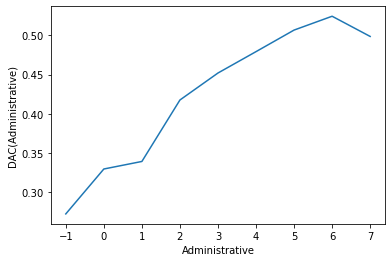

In [159]:
feature=features[0]
idx = np.argmax(features==features[0])
dac_1d,x_axis = get_1D_dac(RF_model,train_X2.to_numpy(),train_y2,S,feat_intervals,feat_di,idx,feature,features)

In [160]:
import scipy

In [161]:
dac_1d

array([0.27197378, 0.32934958, 0.33898426, 0.41749358, 0.45196595,
       0.47927919, 0.50681724, 0.52448598, 0.49869199])

In [162]:
x_axis

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

In [163]:
scipy.integrate.trapz(dac_1d,x_axis)

3.4337086745582814

In [164]:
def get_1D_integral(model, X, y, S, feat_intervals, feat_di, idx, feature, features):
    S[idx] = 1
    dac_1D = make_curve_forest(model, X, y, S, feat_intervals[idx], feat_di[idx], C=1, continuous_y=False)
    
    x_axis = np.arange(feat_intervals[idx][0], feat_intervals[idx][1], feat_di[idx])
    integral = scipy.integrate.trapz(dac_1D,x_axis)
    
    return integral

In [165]:
integrals = []
feat_di = [1]*len(features)

for i in range(len(features)):
    feature = features[i]
    idx = np.argmax(features==features[i])
    
    integral = get_1D_integral(RF_model,train_X2.to_numpy(),train_y2,S,feat_intervals,feat_di,idx,feature,features)
    integrals.append(integral)

In [166]:
integrals

[3.4337086745582814,
 8.836584045658583,
 9.566419009542615,
 8.84832065698372,
 7.607250582855882,
 16.295592249091428,
 1.7351332297110127,
 1.805145452964879,
 11.120856816996211,
 2.175498580872079,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.3047849008061774,
 2.346648502999341,
 1.888275834332264,
 5.557300360779024,
 0.0]

In [167]:
import pickle
pickle.dump(integrals,open("shop_integrals.pkl","wb"))
#old_integrals=pickle.load(open("shop_integrals.pkl","rb"))

In [168]:
dac_integral = pd.DataFrame(integrals,index=features,columns=["integral"])
dac_features = dac_integral[dac_integral["integral"]>5].index

In [169]:
dac_integral[dac_integral["integral"]>5]

,integral
Administrative_Duration,8.836584
Informational,9.566419
Informational_Duration,8.848321
ProductRelated,7.607251
ProductRelated_Duration,16.295592
PageValues,11.120857
TrafficType,5.557300


In [170]:
dac_features

Index(['Administrative_Duration', 'Informational', 'Informational_Duration',
       'ProductRelated', 'ProductRelated_Duration', 'PageValues',
       'TrafficType'],
      dtype='object')

### Feature Engineering with DAC

In [171]:
def get_importance_scores(model, score_type='mdi', X=None, Y=None):
    if score_type == 'mdi':
        return model.feature_importances_
    elif score_type == 'mda':
        return eli5.sklearn.PermutationImportance(model, random_state=42, n_iter=4).fit(X, Y).feature_importances_
    else:
        raise NotImplementedError(f'{score_type} not implemented')

In [172]:
feature_scores_mdi = get_importance_scores(RF_model, score_type='mdi', X=test_X2, Y=test_y2)

In [173]:
feature_scores_mdi

array([4.82385952e-02, 4.71080976e-02, 1.62621917e-02, 2.00588604e-02,
       6.04981979e-02, 7.28361135e-02, 4.45541803e-02, 7.33663593e-02,
       4.36337622e-01, 2.51606803e-03, 6.71820527e-03, 1.55167762e-04,
       3.73819810e-03, 1.54694320e-03, 5.82472825e-03, 9.25842686e-03,
       3.34455511e-02, 3.77144489e-03, 4.68094183e-03, 2.68436788e-04,
       1.84534016e-02, 1.69011313e-02, 1.52595185e-02, 2.39782126e-02,
       2.48892244e-02, 9.33418177e-03])

In [174]:
feat_num = np.argsort(feature_scores_mdi)[-1]

In [175]:
features[feat_num]

'PageValues'

In [176]:
continuous_y = False

num_features = len(features)
feat_num = np.argsort(feature_scores_mdi)[-1]

S = np.zeros(num_features)
S[feat_num]= 1

In [177]:
## dac.interactions_forest does not exist
X_alt_train = dac(forest=RF_model, input_space_x=train_X2.to_numpy(), outcome_space_y=train_y2,assignment=train_X2.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [178]:
pickle.dump(X_alt_train,open("shop_X_alt_train.pkl","wb"))

In [191]:
# X_alt_train.shape

(16821, 1)

In [180]:
X_alt_test = dac(forest=RF_model, input_space_x=train_X2.to_numpy(), outcome_space_y=train_y2, 
                                              assignment=test_X2.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [181]:
pickle.dump(X_alt_test,open("shop_X_alt_test.pkl","wb"))

In [182]:
S = np.zeros(num_features)
feat_num = np.argmax(features=='ProductRelated_Duration')
S[feat_num]= 1

X_alt_other = dac(forest=RF_model, input_space_x=train_X2.to_numpy(), outcome_space_y=train_y2,assignment=train_X2.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [183]:
pickle.dump(X_alt_test,open("shop_X_alt_other.pkl","wb"))

In [184]:
X_alt_othertest = dac(forest=RF_model, input_space_x=train_X2.to_numpy(), outcome_space_y=train_y2, 
                                              assignment=test_X2.to_numpy(), S=S, continuous_y=continuous_y).reshape(-1, 1)

In [185]:
pickle.dump(X_alt_othertest,open("X_alt_othertest.pkl","wb"))

## Models with DAC

### Logistic Regression

#### Feature Selection

In [186]:
train_X3 = train_X2[dac_features]
test_X3 = test_X2[dac_features]

train_X4 = np.hstack((train_X2.to_numpy(),X_alt_train))
test_X4 = np.hstack((test_X2.to_numpy(),X_alt_test))

train_X5 = np.hstack((train_X2.to_numpy(),X_alt_other))
test_X5 = np.hstack((test_X2.to_numpy(),X_alt_othertest))

In [187]:
LR_model = LogisticRegression(penalty='none')
LR_model.fit(train_X3,train_y2)

LogisticRegression(penalty='none')

In [188]:
cross_validate_scores(LR_model, train_X3, train_y2)

LogisticRegression(penalty='none')
-------------------
fit_time: 0.076202
score_time: 0.016281
test_accuracy: 0.820849
test_precision: 0.820002
test_f1: 0.683571
test_roc_auc: 0.892029


In [189]:
pred = LR_model.predict(test_X3)

accuracy=accuracy_score(test_y2, pred)
precision=precision_score(test_y2, pred)
f1=f1_score(test_y2, pred)
roc = roc_auc_score(test_y2, pred)

metrics = [accuracy,precision,f1,roc]
metric_names = ['accuracy','precision','f1','ROC-AUC']

for i in range(len(metrics)):
    print(metric_names[i]+": ",metrics[i])

accuracy:  0.8081023454157783
precision:  0.8337182448036952
f1:  0.66728280961183
ROC-AUC:  0.7487803315991124


#### Feature Engineering

In [190]:
LR_model = LogisticRegression(penalty='none',max_iter=1000)
LR_model.fit(train_X4,train_y2)

cross_validate_scores(LR_model, train_X4, train_y2)

LogisticRegression(max_iter=1000, penalty='none')
-------------------
fit_time: 0.456487
score_time: 0.011177
test_accuracy: 0.879232
test_precision: 0.816120
test_f1: 0.817289
test_roc_auc: 0.929923


In [191]:
pred = LR_model.predict(test_X4)

accuracy=accuracy_score(test_y2, pred)
precision=precision_score(test_y2, pred)
f1=f1_score(test_y2, pred)
roc = roc_auc_score(test_y2, pred)

metrics = [accuracy,precision,f1,roc]
metric_names = ['accuracy','precision','f1','ROC-AUC']

for i in range(len(metrics)):
    print(metric_names[i]+": ",metrics[i])

accuracy:  0.8603411513859275
precision:  0.8146341463414634
f1:  0.7927215189873418
ROC-AUC:  0.8395236606251484


In [192]:
LR_model = LogisticRegression(penalty='none',max_iter=1000)
LR_model.fit(train_X5,train_y2)

cross_validate_scores(LR_model, train_X5, train_y2)

LogisticRegression(max_iter=1000, penalty='none')
-------------------
fit_time: 1.280628
score_time: 0.023957
test_accuracy: 0.832713
test_precision: 0.809978
test_f1: 0.717711
test_roc_auc: 0.907578


In [193]:
pred = LR_model.predict(test_X5)

accuracy=accuracy_score(test_y2, pred)
precision=precision_score(test_y2, pred)
f1=f1_score(test_y2, pred)
roc = roc_auc_score(test_y2, pred)

metrics = [accuracy,precision,f1,roc]
metric_names = ['accuracy','precision','f1','ROC-AUC']

for i in range(len(metrics)):
    print(metric_names[i]+": ",metrics[i])

accuracy:  0.8208955223880597
precision:  0.8280922431865828
f1:  0.7015985790408525
ROC-AUC:  0.7708994968122233


### Random Forest

#### Feature Selection

In [194]:
RF_model = RandomForestClassifier(n_estimators=120,random_state=0)
RF_model.fit(train_X3, train_y2)

pred = RF_model.predict(test_X3)

In [195]:
print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1099  128]
 [ 131  518]]
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89      1227
         1.0       0.80      0.80      0.80       649

    accuracy                           0.86      1876
   macro avg       0.85      0.85      0.85      1876
weighted avg       0.86      0.86      0.86      1876

0.8619402985074627


#### Feature Engineering

In [196]:
RF_model = RandomForestClassifier(n_estimators=120,random_state=0)
RF_model.fit(train_X4, train_y2)

pred = RF_model.predict(test_X4)

In [197]:
print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1122  105]
 [ 115  534]]
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1227
         1.0       0.84      0.82      0.83       649

    accuracy                           0.88      1876
   macro avg       0.87      0.87      0.87      1876
weighted avg       0.88      0.88      0.88      1876

0.8827292110874201


In [198]:
RF_model = RandomForestClassifier(n_estimators=120,random_state=0)
RF_model.fit(train_X5, train_y2)

pred = RF_model.predict(test_X5)

print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1127  100]
 [ 121  528]]
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      1227
         1.0       0.84      0.81      0.83       649

    accuracy                           0.88      1876
   macro avg       0.87      0.87      0.87      1876
weighted avg       0.88      0.88      0.88      1876

0.8821961620469083


### Boosted Trees

#### Feature Selection

In [211]:
boost = AdaBoostClassifier(n_estimators=20, random_state=0, algorithm='SAMME')
boost.fit(train_X3, train_y2)

pred = boost.predict(test_X3)

In [212]:
print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1072  155]
 [ 121  528]]
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89      1227
         1.0       0.77      0.81      0.79       649

    accuracy                           0.85      1876
   macro avg       0.84      0.84      0.84      1876
weighted avg       0.86      0.85      0.85      1876

0.8528784648187633


#### Feature Engineering

In [213]:
boost = AdaBoostClassifier(n_estimators=20, random_state=0, algorithm='SAMME')
boost.fit(train_X4, train_y2)

pred = boost.predict(test_X4)

print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1094  133]
 [ 125  524]]
              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1227
         1.0       0.80      0.81      0.80       649

    accuracy                           0.86      1876
   macro avg       0.85      0.85      0.85      1876
weighted avg       0.86      0.86      0.86      1876

0.8624733475479744


In [214]:
boost = AdaBoostClassifier(n_estimators=20, random_state=0, algorithm='SAMME')
boost.fit(train_X5, train_y2)

pred = boost.predict(test_X5)

print(confusion_matrix(test_y2,pred))
print(classification_report(test_y2,pred))
print(accuracy_score(test_y2, pred))

[[1085  142]
 [ 139  510]]
              precision    recall  f1-score   support

         0.0       0.89      0.88      0.89      1227
         1.0       0.78      0.79      0.78       649

    accuracy                           0.85      1876
   macro avg       0.83      0.84      0.83      1876
weighted avg       0.85      0.85      0.85      1876

0.8502132196162047
